CGAN 조건부 생성 모델

In [2]:
c_size = 100
c_n = 10
in_shape = (28, 28, 1)

In [3]:
from keras.datasets import mnist
import tensorflow as tf
(train_x, train_y), (test_x, test_y) = mnist.load_data()

s_train_x = train_x.astype('float32') / 255.
c_g_train_x = s_train_x.reshape(-1, 28, 28, 1) * 2.-1
train_dataset = tf.data.Dataset.from_tensor_slices((c_g_train_x, train_y)).shuffle(1000)
train_dataset = train_dataset.batch(32, drop_remainder = True).prefetch(1)

s_test_x = test_x.astype('float32') / 255.
c_g_test_x = s_test_x.reshape(-1, 28, 28, 1) * 2.-1
test_dataset = tf.data.Dataset.from_tensor_slices((c_g_test_x, test_y)).shuffle(1000)
test_dataset = test_dataset.batch(32, drop_remainder = True).prefetch(1)

In [4]:
import numpy as np
print(np.prod(in_shape))
print(c_g_train_x.shape)

784
(60000, 28, 28, 1)


생성자

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Conv2D, Flatten, Dense, LeakyReLU, BatchNormalization, Input, Reshape, Conv2DTranspose, Multiply, Embedding, Concatenate

In [6]:
gn_m=Sequential()
gn_m.add(Dense(7 * 7 * 256, input_shape = (c_size,)))
gn_m.add(Reshape((7, 7, 256)))
gn_m.add(BatchNormalization())
gn_m.add(Conv2DTranspose(128, 3, 2, padding='same', activation = LeakyReLU(0.2)))
gn_m.add(BatchNormalization())
gn_m.add(Conv2DTranspose(64, 3, 1, padding='same', activation = LeakyReLU(0.2)))
gn_m.add(BatchNormalization())
gn_m.add(Conv2DTranspose(1, 3, 2, padding='same', activation = 'tanh'))

In [7]:
z = Input(shape = (c_size, ))
label = Input(shape = (1, ), dtype = 'int32')
label_embedding = Embedding(c_n, c_size, input_length = 1)(label)
label_embedding = Flatten()(label_embedding)
in_data = Multiply()([z, label_embedding])
g_img = gn_m(in_data)
cg_g_m = (Model([z, label], g_img))

판별자

In [8]:
di_m = Sequential()
di_m.add(Conv2D(64, 3, 2, padding = 'same', activation = LeakyReLU(0.2), input_shape = (in_shape[0], in_shape[1], in_shape[2] + 1)))
di_m.add(Conv2D(64, 3, 2, padding='same', activation = LeakyReLU(0.2)))
di_m.add(Conv2D(128, 3, 2, padding='same', activation = LeakyReLU(0.2)))
di_m.add(Flatten())
di_m.add(Dense(1, activation = 'sigmoid'))

In [9]:
img = Input(shape = in_shape)
label = Input(shape = (1, ), dtype = 'int32')
label_embedding = Embedding(c_n, np.prod(in_shape), input_length = 1)(label)
label_embedding = Flatten()(label_embedding)
label_embedding = Reshape(in_shape)(label_embedding)
in_data = Concatenate(axis = -1)([img, label_embedding])
out_put = di_m(in_data)
cg_di_m = (Model([img, label], out_put))

In [10]:
z = Input(shape = (c_size,))
label = Input(shape = (1, ))
img = cg_g_m([z, label])
out_put = cg_di_m([img, label])
cgn_m = Model([z, label], out_put)

In [11]:
cg_di_m.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'acc')
cg_di_m.trainable = False
cgn_m.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [12]:
cgn_m.layers

In [13]:
import matplotlib.pyplot as plt

def m_img_show(imgs,n_c=None):
  img_n_c=  n_c or len(imgs)
  img_n_r=(len(imgs)-1)//n_c+1
  if imgs.shape[-1]==1:
    imgs=imgs.squeeze(axis=-1)
  plt.figure(figsize=(img_n_c,img_n_r))
  for idx,im in enumerate(imgs):
    plt.subplot(img_n_r,img_n_c,idx+1)
    im = 255 - im
    plt.imshow(im,cmap = 'gray')
    plt.axis('off')

(32,) tf.Tensor([1 6 2 9 7 6 5 3 4 4 4 1 5 4 1 3 4 3 1 7 6 6 2 7 0 9 7 5 7 3 0 2], shape=(32,), dtype=uint8)
(32, 28, 28, 1)


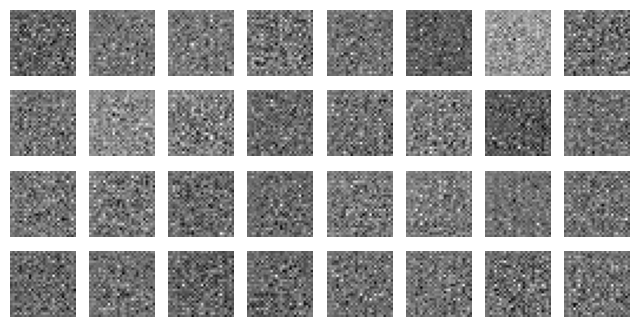

In [14]:
for x, y in train_dataset:
    t = y
    break
z = tf.random.normal([32, 100])
g_img = cg_g_m.predict([z, t], verbose = 0)
print(t.shape, t)
print(g_img.shape)
m_img_show(g_img, 8)

In [15]:
for x, y in train_dataset:
    z = tf.random.normal([32, 100])
    g_img = cg_g_m.predict([z, y], verbose = 0)
    # 1
    n_x = tf.concat([x, g_img], axis = 0)
    n_y = tf.concat([y, y], axis = 0)
    y1 = tf.constant([[1.]] * 32 + [[0.]] * 32)
    print(n_x.shape, n_y.shape, y1.shape)

    # 2
    loss1 = cg_di_m.train_on_batch([g_img, y], tf.constant([[0.]] * 32))
    loss2 = cg_di_m.train_on_batch([x, y], tf.constant([[1.]] * 32))
    print(loss1)
    print(loss2)
    print("판별 loss", (loss1[0] + loss2[0]) * 0.5)
    print('판별 정확도(best : 0.5)', (loss1[1] + loss2[1]) * 0.5)
    #m_img_show(tf.squeeze(x), 8)
    break


(64, 28, 28, 1) (64,) (64, 1)
[0.6934791803359985, 0.40625]
[0.8302156925201416, 0.0]
판별 loss 0.7618474364280701
판별 정확도(best : 0.5) 0.203125


In [16]:
def train_cgn(data, b_size, c_size, ec):
    g_m = cg_g_m
    di_m = cg_di_m
    for i in range(ec):
        print(f"{i + 1}회")
        for x, y in data:
            # 판별자(판별 모델)
            z = tf.random.normal([b_size, c_size])
            g_img = g_m.predict([z, y], verbose = 0)
            loss1 = cg_di_m.train_on_batch([g_img, y], tf.constant([[0.]] * 32)) # F
            loss2 = cg_di_m.train_on_batch([x, y], tf.constant([[1.]] * 32)) # T

            # 생성자(통합 모델)
            z = tf.random.normal([b_size, c_size])
            g_loss = cgn_m.train_on_batch([z, y], tf.constant([[1.]] * 32))

        print("판별 loss", (loss1[0] + loss2[0]) * 0.5)
        print('판별 정확도(best : 0.5)', (loss1[1] + loss2[1]) * 0.5)
        print("생성 loss", g_loss)

        if i % 100 == 0:
            print("진짜")
            m_img_show(tf.squeeze(x), 8)
            plt.show()
            print("생성")
            m_img_show(tf.squeeze(g_img), 8)
            plt.show()

1회
판별 loss 2.008266619668575e-05
판별 정확도(best : 0.5) 1.0
생성 loss 2.9249557087496214e-07
진짜


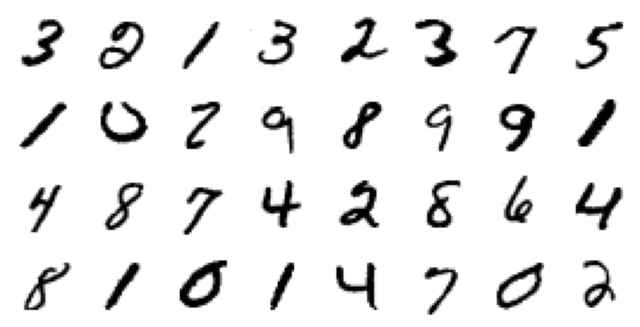

생성


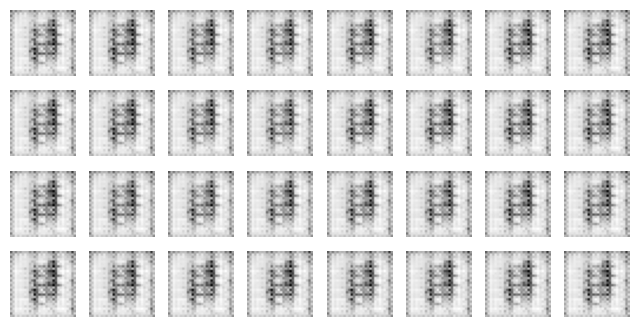

2회
판별 loss 0.06598548963665962
판별 정확도(best : 0.5) 0.984375
생성 loss 0.24287429451942444
3회
판별 loss 0.0012437555124051869
판별 정확도(best : 0.5) 1.0
생성 loss 0.911718487739563
4회
판별 loss 0.003900668991263956
판별 정확도(best : 0.5) 1.0
생성 loss 6.898266792297363
5회
판별 loss 0.0005033399138483219
판별 정확도(best : 0.5) 1.0
생성 loss 1.067270040512085
6회
판별 loss 0.005377343113650568
판별 정확도(best : 0.5) 1.0
생성 loss 2.0037195682525635
7회
판별 loss 0.002704260405153036
판별 정확도(best : 0.5) 1.0
생성 loss 6.716947555541992
8회
판별 loss 0.0017793684091884643
판별 정확도(best : 0.5) 1.0
생성 loss 6.502729892730713
9회
판별 loss 0.001248303053174027
판별 정확도(best : 0.5) 1.0
생성 loss 5.013596534729004
10회
판별 loss 0.005454675621336946
판별 정확도(best : 0.5) 1.0
생성 loss 5.436929702758789
11회
판별 loss 0.0003208889684606207
판별 정확도(best : 0.5) 1.0
생성 loss 25.04839324951172
12회
판별 loss 0.024448795244867254
판별 정확도(best : 0.5) 0.984375
생성 loss 30.241182327270508
13회
판별 loss 0.0002079074768062128
판별 정확도(best : 0.5) 1.0
생성 loss 9.87148380279541
14회
판별 

In [ ]:
train_cgn(test_dataset, 32, 100, 100)

ProGAN

점진적으로 커진다

In [1]:
# down / up
import tensorflow as tf
import keras as K

In [3]:
def up_s_l(layer, us_f):
    h, w = layer.get_shape()[1:3]
    size = (us_f * h, us_f * w)
    up_img = tf.image.resize(layer, size)
    return up_img

In [4]:
def s_last_l(layers, ap):
    last_f_train_l = layers[-2]
    last_up_l = up_s_l(last_f_train_l, 2)
    n_l = layers[-1]

    assert n_l.get_shape() == last_up_l.get_shape()
    new_l = (1 - ap) * last_up_l + n_l * ap
    return new_l

In [5]:
def mi_bc_std_l(layers, gr_size = 4): # 미니 배치 표준편차
    # 배치 갯수 맞게 조정
    gr_size = K.backend.minimum(gr_size, tf.shape(input)[0])

    shape = list(K.in_shape(input))
    shape[0] = tf.shape(input)[0]

    minibatch = K.backend.reshape(layers, (gr_size, -1, shape[1], shape[2], shape[3]))

    minibatch -= tf.reduce_mean(minibatch, axis = 0, keepdimns = True) # 그룹 평균 계산
    minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0) # 그룹 분산 계산
    minibatch = K.backend.square(minibatch + 1e-8) #그룹 표준편차 계산
    minibatch = tf.reduce_mean(minibatch, axis = [1, 2, 3]) # [M, 1, 1, 1] 특성 맵 평균화를 통한 픽셀 도출
    minibatch = K.backend.tile(minibatch, [gr_size, 1, shape[2], shape[3]]) # 스칼라 값을 그룹과 픽셀에 맞게 변환
    return K.backend.concatenate([layers, minibatch], axis = 1)

In [6]:
# 균등 학습률
import numpy as np
def eq_lr(shape, gain, fan_in = None):
    if fan_in is None:
        fan_in = np.prod(shape[: -1])
        std = gain / K.sqrt(fan_in)
        wscale = K.constraints(std, name = 'wscale', dtype = np.float32)
        ad_w = K.get_value('layer', shape = shape, initializer = tf.initializers.random_normal()) + wscale
        return ad_w
        # 픽셀정규화

ProGAN

In [7]:
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt

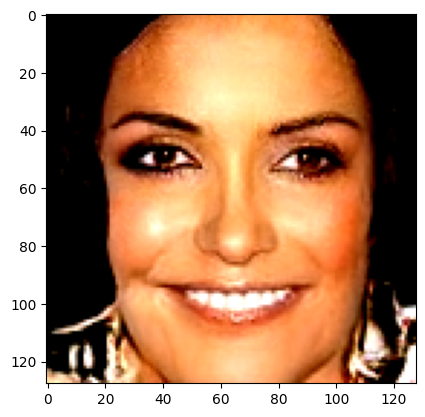

In [8]:
m = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')

# 512짜리 이미지 한개
in_v = tf.random.normal([1, 512], seed = 11)
g_img = m(in_v)
plt.imshow(g_img.numpy().reshape(128, 128, 3))

TF_HUB 이미지 생성 모델

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

c_size = 512

def tr_v(v1, v2, n_step):
  v1_n = tf.norm(v1)
  v2_n = tf.norm(v2)

  v2_nn = v2 * (v1_n / v2_n)

  v = []

  for sp in range(n_step):
    i_p = v1 + (v2_nn - v1) * sp / (n_step - 1)
    i_p_n = tf.norm(i_p)
    i_p_nn = i_p * (v1_n / i_p_n)
    v.append(i_p_nn)

  return tf.stack(v)

In [10]:
m = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')

s_v = tf.random.normal([1, 512], seed = 3)
e_v = tf.random.normal([1, 512], seed = 1)
out_v = tr_v(s_v, e_v, 25)
g_imgs = m(out_v)

In [12]:
g_imgs.shape

TensorShape([25, 128, 128, 3])

In [13]:
import imageio
from IPython import display
def n_a(imgs):
    imgs = np.array(imgs)
    ck_img = np.clip(imgs * 255, 0, 255).astype(np.uint8)
    imageio.mimsave("./animation.gif", ck_img)
    with open("./animation.gif", 'rb') as f:
        display.display(display.Image(data = f.read(), height = 300))


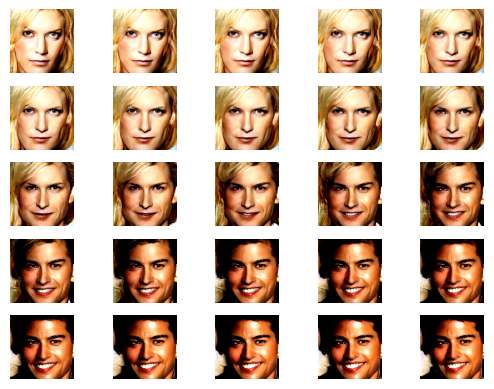

In [11]:
for n, img in enumerate(g_imgs):
  plt.subplot(5,5, n + 1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

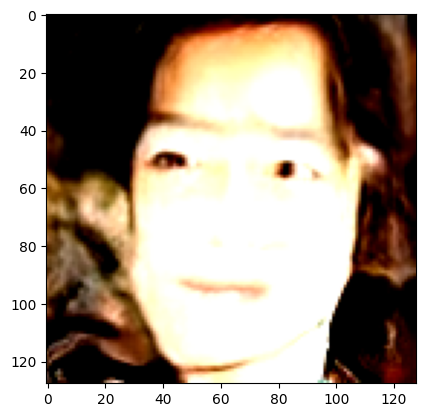

In [17]:
m = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')

in_v = tf.random.normal([1, 512], seed = 12)
g_imgs = m(in_v)
ck_img = g_imgs[0]
plt.imshow(ck_img)

In [ ]:
m = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')  # proGAN
in_v = tf.random.normal([1, 512], seed = 11)
g_img = m(in_v)

In [15]:
in_v = tf.random.normal([1, 512], seed = 11)
in_v.shape

TensorShape([1, 512])

In [ ]:
tf.Variable(in_v)

In [21]:
n_sp = 200
v_data = tf.Variable(in_v)
op = tf.optimizers.Adam(0.01)
loss = tf.losses.MeanAbsoluteError(reduction = 'sum')
imgs = []
losses = []
for sp in range(n_sp):
    with tf.GradientTape() as tape:
        g_img = m(v_data.read_value())
        if sp % 20 == 0:
            imgs.append(g_img.numpy().reshape(128, 128, 3))
        t_img_di = loss(g_img, ck_img)
        rg = tf.abs(tf.norm(v_data) - np.sqrt(512))

        end_loss = t_img_di + rg
        losses.append(end_loss)
    gd = tape.gradient(end_loss, [v_data])
    op.apply_gradients(zip(gd, [v_data]))

In [ ]:
len(imgs), len(losses)

In [19]:
ck_img.shape

TensorShape([128, 128, 3])